In [135]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, make_scorer, confusion_matrix
from imblearn.over_sampling import SMOTE



## Data Preperation

In [123]:
data = pd.read_csv(".\student_performance\StudentPerformanceFactorsAdjusted.csv")

## Create bins for the target variable, that way the data can easily be worked with by the Naive Bayes model
def aggregate_classes(score):
    if score <= 60:
        return "55-60"
    elif score <= 65:
        return "61-65"
    elif score <= 70:
        return "66-70"
    elif score <= 75:
        return "71-75"
    elif score <= 80:
        return "76-80"
    else:
        return "81+"

In [124]:
X = data.drop(['Exam_Score'], axis=1)
y = data['Exam_Score'].map(aggregate_classes)

## Encode the data using OrdinalEncoder, so that categorical data can be easily worked with by the Naive Bayes model
encoder = OrdinalEncoder()
X_encoded = encoder.fit_transform(X)
## Determines number of categories for each feature
n_categories = [len(encoder.categories_[i]) for i in range(len(encoder.categories_))]
max_categories = max(n_categories)

## Model Training and Evaluation


			Classification Report
               precision    recall  f1-score   support

       55-60       0.00      0.00      0.00        24
       61-65       0.84      0.58      0.68       399
       66-70       0.64      0.97      0.77       667
       71-75       0.89      0.11      0.19       223
       76-80       0.00      0.00      0.00         3
         81+       0.00      0.00      0.00         6

    accuracy                           0.68      1322
   macro avg       0.39      0.28      0.27      1322
weighted avg       0.72      0.68      0.63      1322
 
Test Set Accuracy: 0.6838124054462935


C:\Users\Ify\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Ify\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Ify\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:

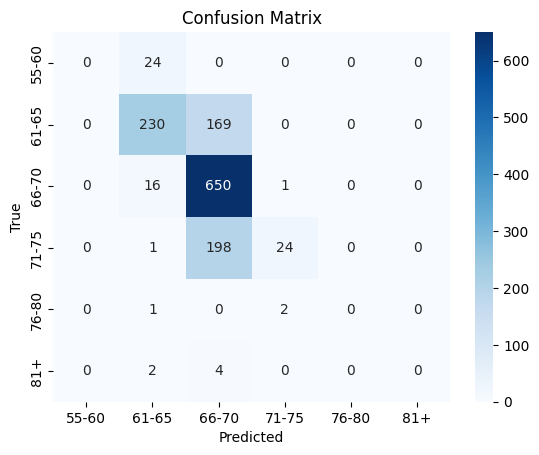

In [130]:
## Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
nb_model = CategoricalNB(min_categories=max_categories)
nb_model.fit(X_train, y_train)
## Test the model
y_pred = nb_model.predict(X_test)

print("\n\t\t\tClassification Report\n", classification_report(y_test, y_pred),"\nTest Set Accuracy:", accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Feature Engineering 


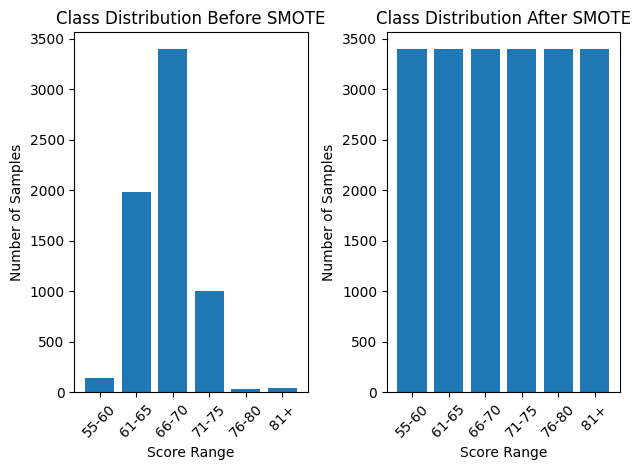

In [134]:
## We'll apply SMOTE to balance the classes and compare the distribution prior to the application
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_encoded, y)

plt.subplot(1, 2, 1)
initial_distribution = y.value_counts().sort_index()
plt.bar(initial_distribution.index, initial_distribution.values)
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Score Range')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
balanced_distribution = pd.Series(y_balanced).value_counts().sort_index()
plt.bar(balanced_distribution.index, balanced_distribution.values)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Score Range')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)    
plt.tight_layout()
plt.show()


			Classification Report
               precision    recall  f1-score   support

       55-60       0.83      0.92      0.87      3393
       61-65       0.67      0.66      0.67      3393
       66-70       0.69      0.75      0.72      3393
       71-75       0.68      0.63      0.65      3393
       76-80       0.78      0.72      0.75      3393
         81+       0.70      0.68      0.69      3393

    accuracy                           0.73     20358
   macro avg       0.73      0.73      0.73     20358
weighted avg       0.73      0.73      0.73     20358
 
Test Set Accuracy: 0.7276746242263483


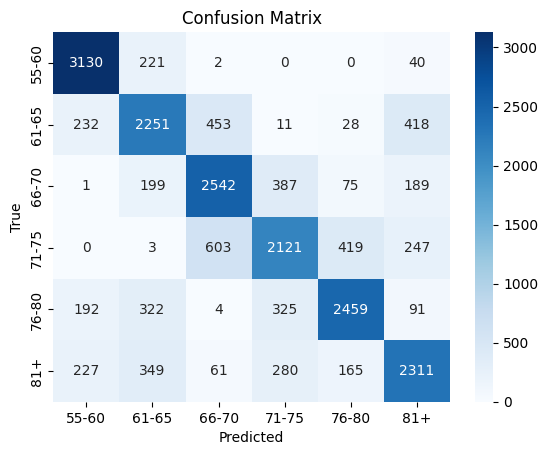

In [127]:
## Retrain the model with the balanced data
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

nb_model_balanced = CategoricalNB(min_categories=max_categories)
nb_model_balanced.fit(X_train_balanced, y_train_balanced)
## Test the balanced model
y_pred_balanced = nb_model_balanced.predict(X_balanced)

print("\n\t\t\tClassification Report\n", classification_report(y_balanced, y_pred_balanced),"\nTest Set Accuracy:", accuracy_score(y_balanced, y_pred_balanced))

cm = confusion_matrix(y_balanced, y_pred_balanced)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Hyperparameter Tuning


In [128]:
## Use grid search to find the best alpha value for Naive Bayes model
param_grid = {
    'alpha': [0.001,0.01, 0.1, 1, 2, 5, 10],
}

NB_grid = GridSearchCV(estimator=nb_model_balanced, param_grid=param_grid, cv=5, scoring='accuracy')
NB_grid.fit(X_train_balanced, y_train_balanced)

## find and store the best alpha value for retraining the model
NB_Best_alpha = NB_grid.best_params_['alpha']

print("Best Alpha:", NB_Best_alpha)
print("Best Score:", NB_grid.best_score_)

Best Alpha: 0.001
Best Score: 0.7293988663807828


In [129]:
## Retrain the model with the best alpha value
NB_Model_Tuned = CategoricalNB(min_categories=max_categories, alpha=NB_Best_alpha)
NB_Model_Tuned.fit(X_train_balanced, y_train_balanced)

## Test the tuned model
y_pred_tuned = NB_Model_Tuned.predict(X_balanced)

print("\n\t\t\tClassification Report\n", classification_report(y_balanced, y_pred_tuned),"\nTest Set Accuracy:", accuracy_score(y_balanced, y_pred_tuned))



			Classification Report
               precision    recall  f1-score   support

       55-60       0.83      0.91      0.87      3393
       61-65       0.67      0.67      0.67      3393
       66-70       0.69      0.75      0.72      3393
       71-75       0.68      0.63      0.65      3393
       76-80       0.78      0.72      0.75      3393
         81+       0.70      0.68      0.69      3393

    accuracy                           0.73     20358
   macro avg       0.73      0.73      0.73     20358
weighted avg       0.73      0.73      0.73     20358
 
Test Set Accuracy: 0.7271342960998134


In [139]:
def plot_feature_importance(model, X, y, feature_names):
    # Calculate permutation importance
    result = permutation_importance(model, X, y, n_repeats=10, random_state=42)
    
    # Get feature importances and standard deviations
    importance = result.importances_mean
    std = result.importances_std
    
    # Sort features by importance
    sorted_idx = np.argsort(importance)
    
    # Create plot
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(sorted_idx)), importance[sorted_idx], xerr=std[sorted_idx],
             align='center')
    
    plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
    plt.xlabel('Permutation Importance')
    plt.title('Feature Importance (Naive Bayes)')
    plt.tight_layout()
    plt.show()


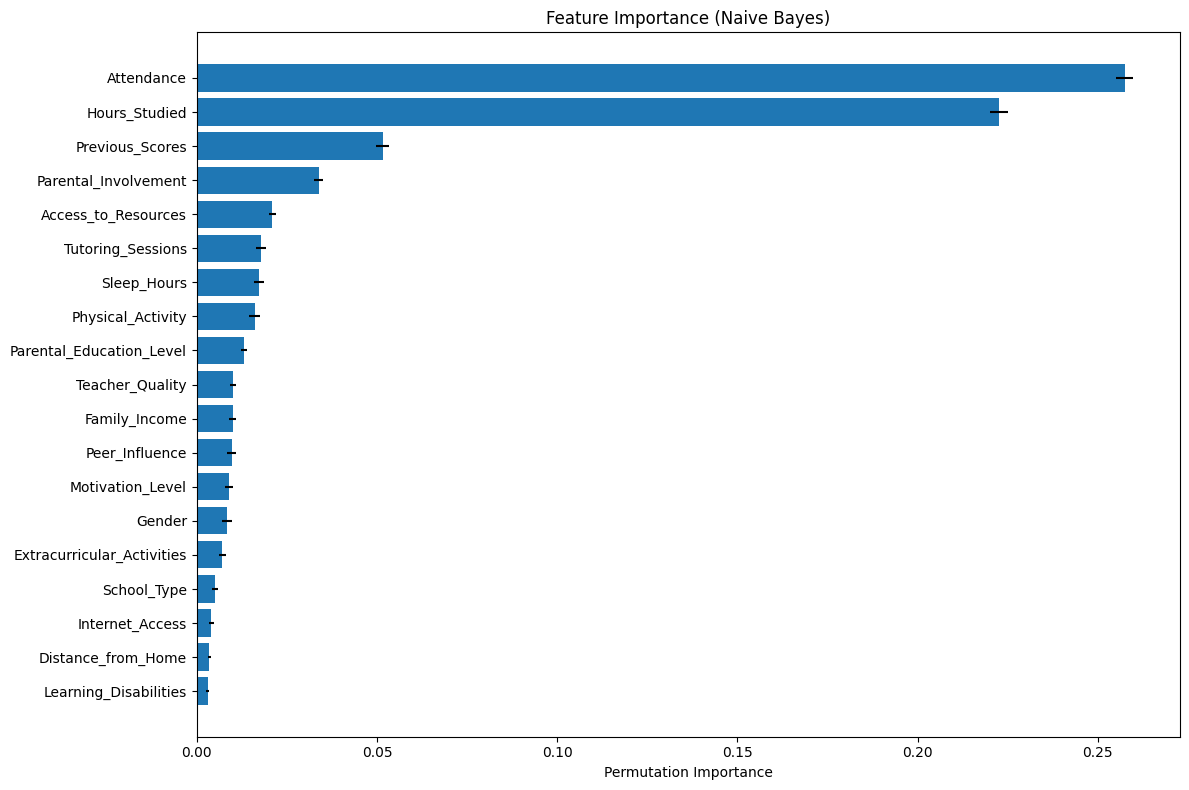

In [140]:
# Plot feature importance for the tuned model
feature_names = X.columns.tolist()
plot_feature_importance(NB_Model_Tuned, X_balanced, y_balanced, feature_names)